In [3]:
from  functions import *
from matplotlib.ticker import MultipleLocator

# Check reproducibility of analysis of images

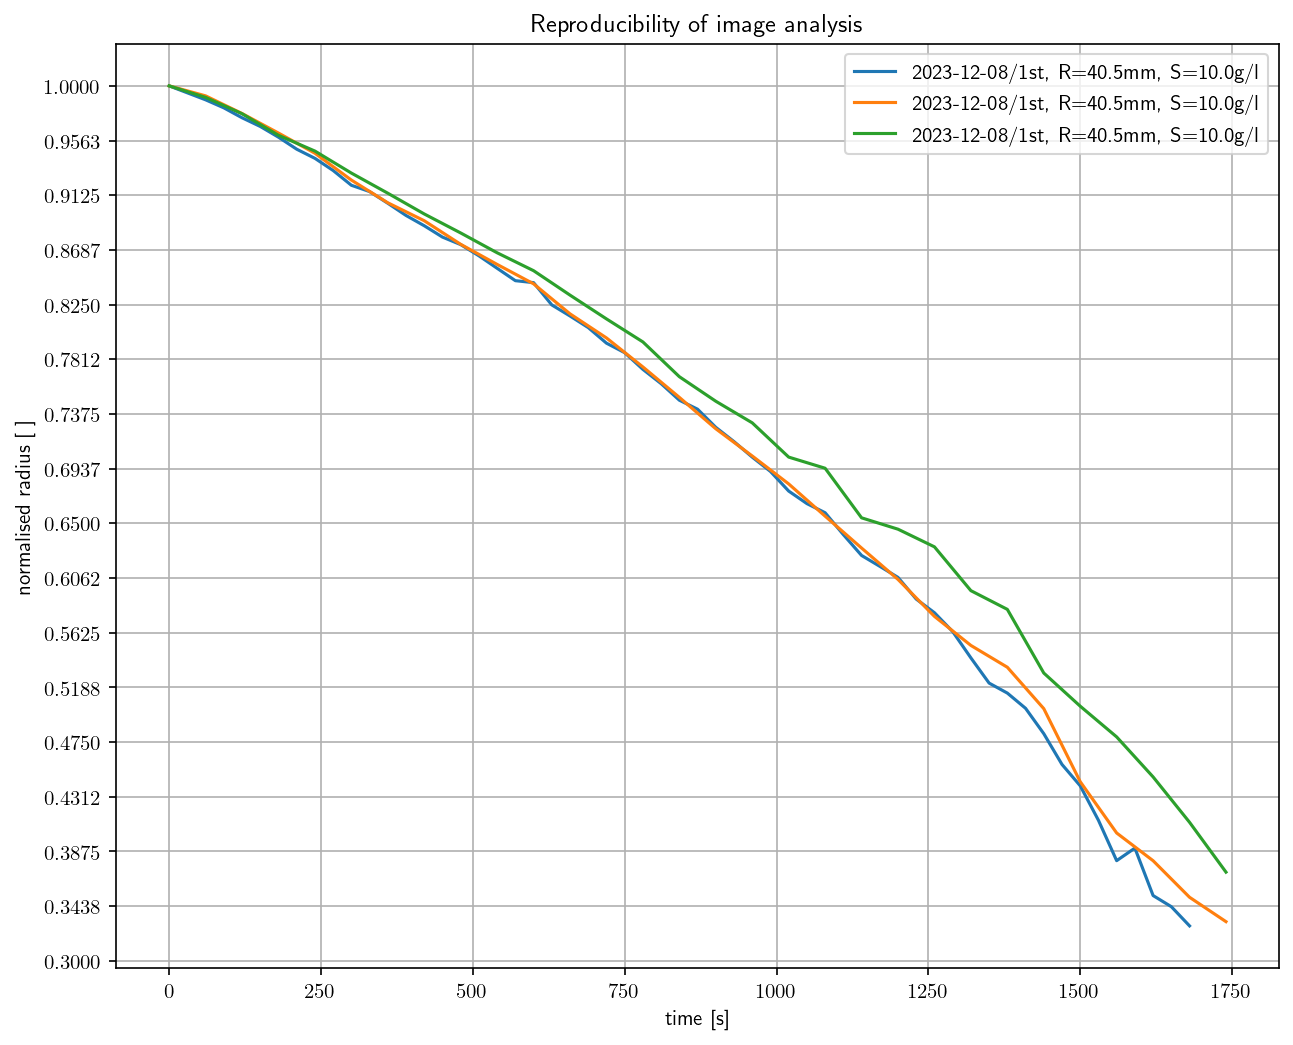

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinder = '2023-12-08/1st'

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for repetition in ['/contours/','/contours_rev1/','/contours_rev2/']:
    dirContours = directory+cylinder+repetition
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)

    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii/radii[0],
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.yticks(ticks=np.linspace(0.3,1,17))
plt.xlabel('time [s]')
plt.ylabel('normalised radius [ ]')
plt.title('Reproducibility of image analysis')
plt.show()

# Radius vs time

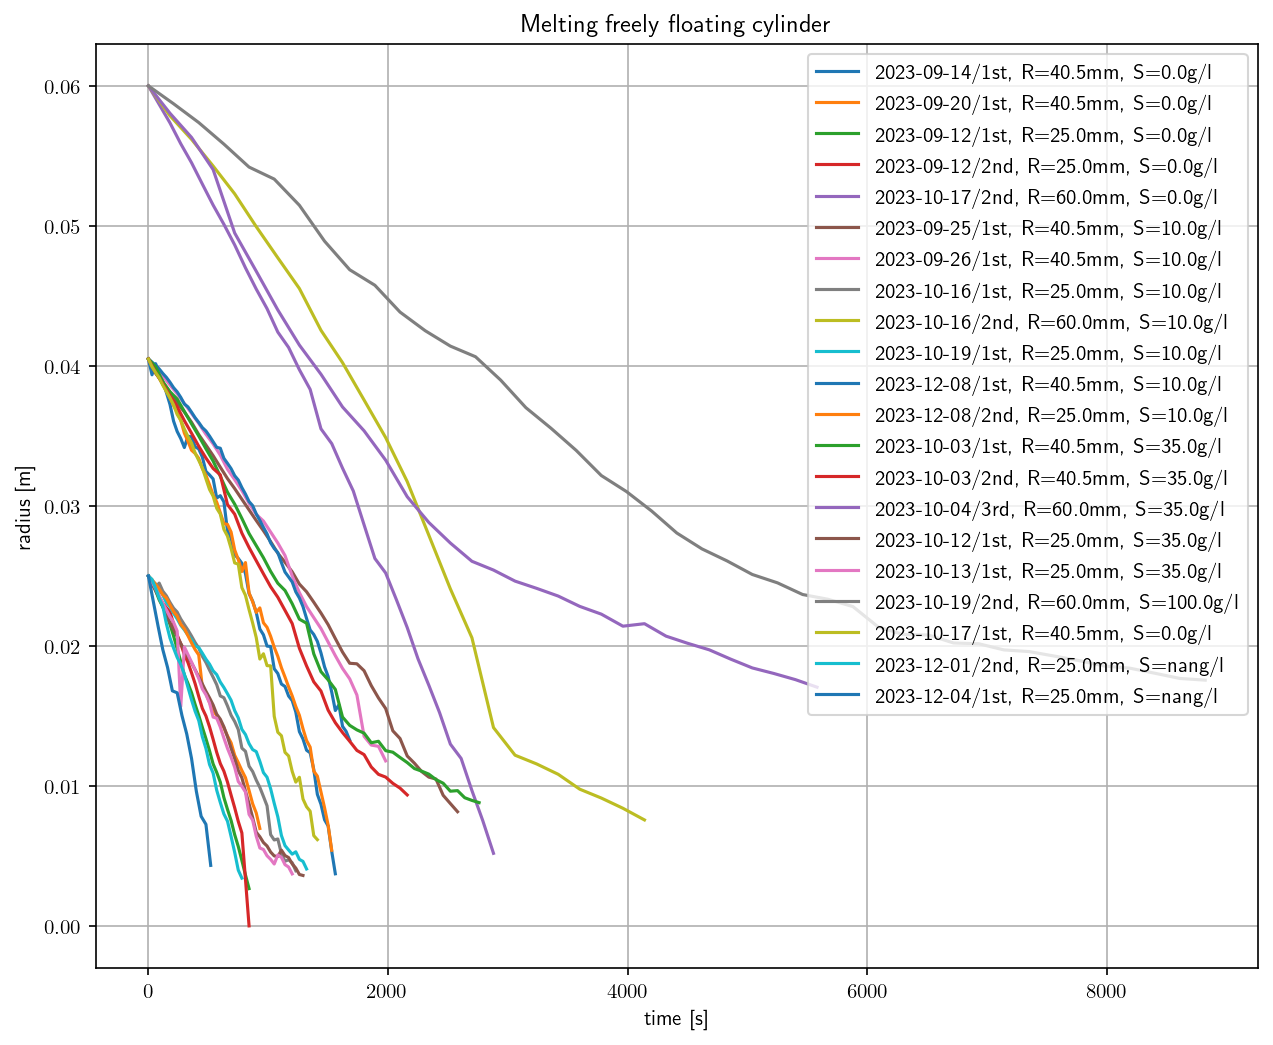

In [ ]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'

cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-09-25/1st','2023-09-26/1st','2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-10-19/2nd', # S=100
             '2023-10-17/1st', # NR
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,8),dpi=150)
plt.rcParams['text.usetex'] = True

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
    # if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = correct_outliers(radii)

    plt.plot(contours_per_shot*interval*np.arange(len(radii)),radii,
            label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') # one shot every 30 seconds

plt.grid()
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('radius [m]')
plt.title('Melting freely floating cylinder')
plt.show()

## Fitting stuff to radii

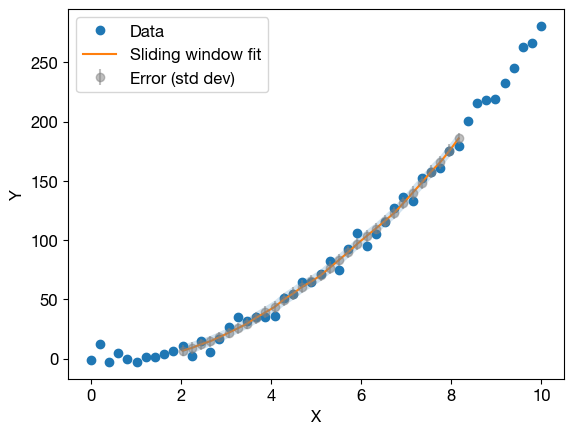

In [23]:
def sliding_window_polyfit(x, y, window_size=10, poly_order=2):
    """
    Fits a second-order polynomial in a sliding window over the data and calculates
    the error for both the fit and the gradient.
    
    Parameters:
    x (array-like): The x-values of the data points.
    y (array-like): The y-values of the data points.
    window_size (int): The size of the sliding window.
    poly_order (int): The order of the polynomial (default is 2 for quadratic).
    
    Returns:
    list of ndarray: List of polynomial coefficients for each window.
    ndarray: Array of fitted y-values only at the central indices.
    ndarray: Array of fitting errors (MSE) only at the central indices.
    ndarray: Array of gradients at the central indices.
    ndarray: Array of gradient errors at the central indices.
    """
    poly_coeffs = []
    y_fitted = np.full_like(y, np.nan, dtype=np.double)  # Array to hold central fitted values
    fit_errors = np.full_like(y, np.nan, dtype=np.double)  # Array to hold errors at central points
    gradient = np.full_like(y, np.nan, dtype=np.double)  # Array to hold gradient at central points
    gradient_errors = np.full_like(y, np.nan, dtype=np.double)  # Array to hold gradient errors
    
    # Loop over data with sliding windows
    for i in range(len(x) - window_size + 1):
        # Select data within the window
        x_window = x[i:i + window_size]
        y_window = y[i:i + window_size]
        
        # Fit a polynomial of the given order to the window data
        coeffs = np.polyfit(x_window, y_window, poly_order)
        poly_coeffs.append(coeffs)
        
        # Generate fitted values for the current window
        y_fit = np.polyval(coeffs, x_window)
        
        # Calculate the mean squared error (MSE) for the current window
        error = np.mean((y_window - y_fit) ** 2)
        
        # Calculate the gradient (slope) of the fit (1st derivative of the polynomial)
        gradient_value = 2 * coeffs[0] * x_window[window_size // 2] + coeffs[1]
        
        # Estimate the gradient error as the standard deviation of residuals divided by the range of x values
        gradient_error = np.sqrt(np.mean((y_window - y_fit) ** 2)) / (x_window[-1] - x_window[0])
        
        # Assign the results to the central index
        central_index = i + window_size // 2
        y_fitted[central_index] = y_fit[window_size // 2]
        fit_errors[central_index] = error
        gradient[central_index] = gradient_value
        gradient_errors[central_index] = gradient_error
    
    return poly_coeffs, y_fitted, fit_errors, gradient, gradient_errors

# Example data
x = np.linspace(0, 10, 50)
y = 3 * x**2 - 2 * x + 1 + np.random.normal(0, 5, x.size)

# Set window size
window_size = 20

# Apply the sliding window polynomial fit
poly_coeffs, y_fitted, fit_errors, gradient, gradient_errors = sliding_window_polyfit(x, y, window_size=window_size)

# Plot the data, the fitted values, and error bars
plt.plot(x, y, 'o', label='Data')
plt.plot(x, y_fitted, '-', label='Sliding window fit')
plt.errorbar(x, y_fitted, yerr=np.sqrt(fit_errors), fmt='o', color='gray', alpha=0.5, label='Error (std dev)')
plt.fill_between(x,y_fitted+np.sqrt(fit_errors),y_fitted-np.sqrt(fit_errors),alpha=0.2)
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


In [13]:
# del remove_and_interpolate_outliers
def remove_and_interpolate_outliers(data, max_relative_decrease=0.1):
    """
    Removes isolated outliers from a 1D monotonically decreasing array by replacing
    them with linearly interpolated values if the decrease is too sharp.
    
    Parameters:
    data (array-like): The input 1D array, expected to be monotonically decreasing.
    max_relative_decrease (float): The maximum allowed relative decrease between consecutive elements.
    
    Returns:
    ndarray: Array with isolated outliers replaced by interpolated values.
    """
    # Convert to a NumPy array for easier manipulation
    data = np.array(data, dtype=np.float64)
    cleaned_data = data.copy()  # Copy the original array to preserve it
    
    # Loop through the array to identify and interpolate outliers
    for i in range(1, len(data) - 1):
        previous_value = cleaned_data[i - 1]
        current_value = data[i]
        next_value = data[i + 1]
        
        # Calculate the relative decrease with the previous value
        relative_decrease = (previous_value - current_value) / previous_value
        
        # Check if current value is an outlier based on the relative decrease threshold
        if relative_decrease > max_relative_decrease:
            # Interpolate as the average of previous and next valid values
            interpolated_value = (previous_value + next_value) / 2
            cleaned_data[i] = interpolated_value
            # print(f"Outlier detected at index {i}: {current_value}, replaced with {interpolated_value}")
    
    return cleaned_data

# Example usage
data = [100, 95, 94, 93, 45, 92, 91, 90, 89]  # 45 is an outlier
cleaned_data = remove_and_interpolate_outliers(data, max_relative_decrease=0.1)
print("Original data:", data)
print("Cleaned data:", cleaned_data)


Original data: [100, 95, 94, 93, 45, 92, 91, 90, 89]
Cleaned data: [100.   95.   94.   93.   92.5  92.   91.   90.   89. ]


/var/folders/dv/4xxtrbpd4ql97bd1_v6ctglh0000gn/T/ipykernel_51644/3939605313.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


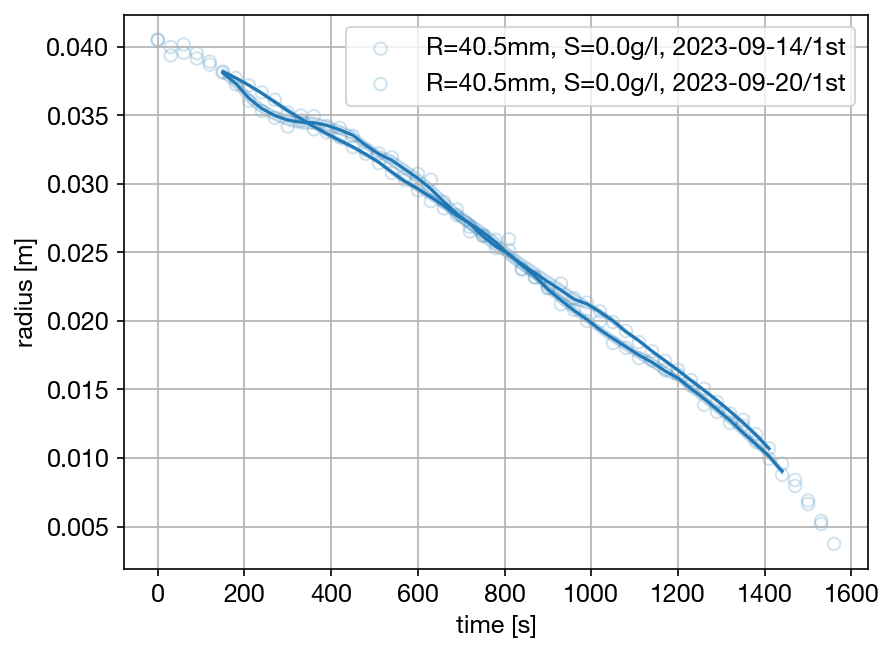

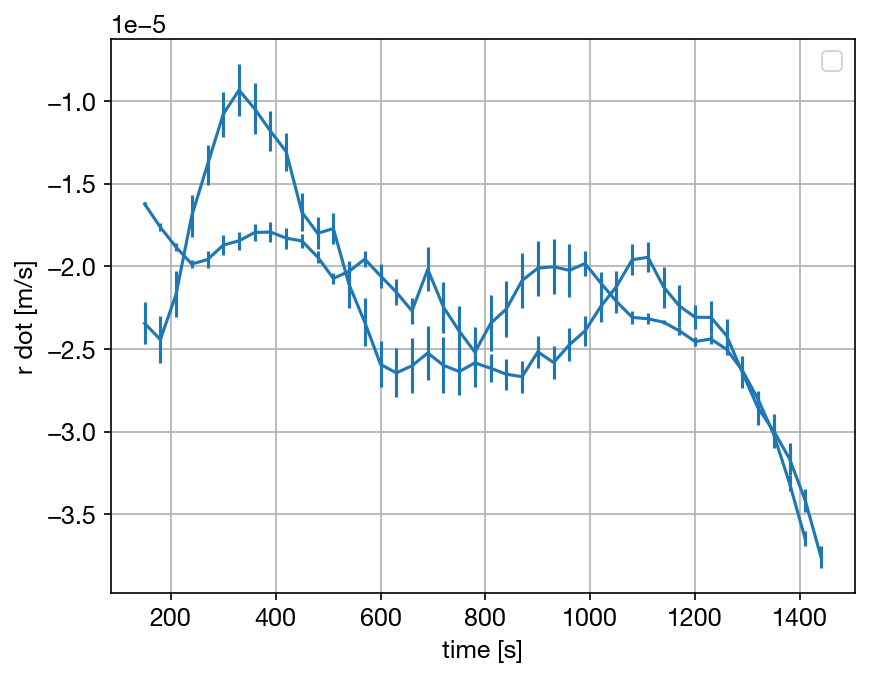

In [25]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

# cylinders = ['2023-10-17/1st','2023-09-20/1st','2023-09-14/1st']

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],2)

_,ax1 = plt.subplots(dpi=150)
_,ax2 = plt.subplots(dpi=150)

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10
        
    if exp_radius!=0.0405: continue
    if exp_sal!=0.: continue

    radii = []
    for it, contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: 
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)/conversion
        radii.append(radius)
    
    radii = remove_and_interpolate_outliers(radii)

    ax1.scatter(contours_per_shot*interval*np.arange(len(radii)),radii,
                label=f'R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l, {cylinder}',
                edgecolors=myColours[ic],facecolors='none',
                alpha=0.2) # one shot every 30 seconds
    
    x = contours_per_shot*interval*np.arange(len(radii))
    poly_coeffs, y_fitted, fit_errors, gradient, gradient_errors = sliding_window_polyfit(x, radii, window_size=10)
    ax1.plot(x,y_fitted,c=myColours[ic])
    ax1.fill_between(x,y_fitted+np.sqrt(fit_errors),y_fitted-np.sqrt(fit_errors), color=myColours[ic],alpha=0.2)
    # res, sigma = fit(func=f'np.polyval([a,b,c,{radii[0]}],x)',xdata=x[:],ydata=radii[:],
    #                  color='Grey',boolRetSigmas=True,legend=False,draw=1,
    #                  ax=ax1)
    ax2.errorbar(x,gradient,yerr=gradient_errors,c=myColours[ic])

for ax in [ax1,ax2]:
    ax.grid()
    ax.legend()
    ax.set(xlabel='time [s]')
ax1.set(ylabel='radius [m]')
ax2.set(ylabel='r dot [m/s]')
plt.show()

## Nusselt vs time with fit

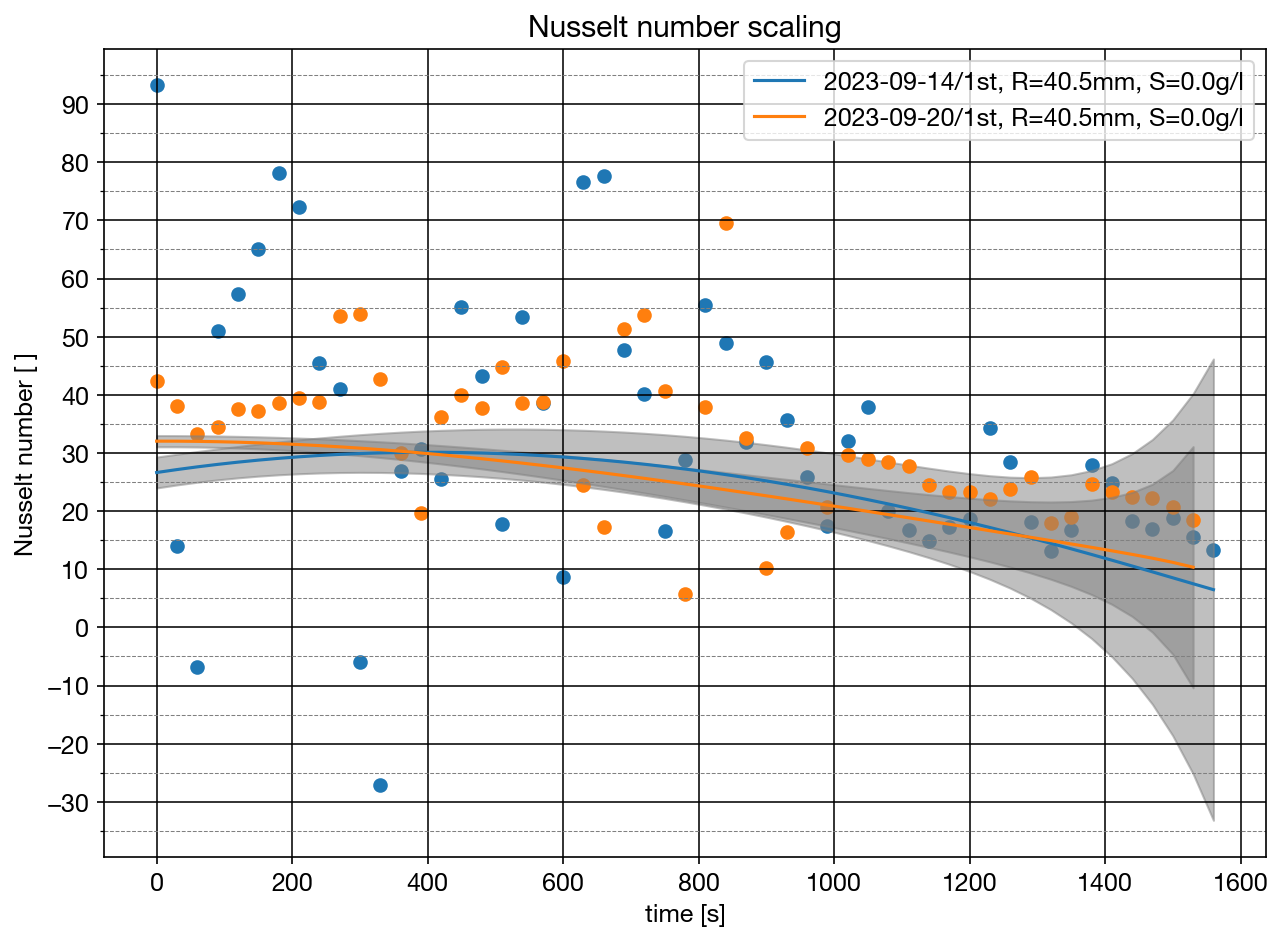

In [22]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd',# S=0
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

plt.figure(figsize=(10,7),dpi=150)

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    # print(contours_per_shot)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    if exp_radius!=0.0405 : continue
    if exp_sal!=0.0 : continue

    radii = []
    perimeters = []
    areas = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        polygon = Polygon(contour)
        radius = np.sqrt(polygon.area/np.pi)
        radii.append(radius)    
        perimeters.append(float(polygon.length))
        areas.append(polygon.area)
    
    radii = remove_and_interpolate_outliers(radii)
    areas = remove_and_interpolate_outliers(areas)
    perimeters = remove_and_interpolate_outliers(perimeters)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion
    perimeters = np.array(perimeters)
    perimeters *= conversion
    areas = np.array(areas)
    areas *= conversion**2

    x = contours_per_shot*interval*np.arange(len(radii))
    a_result, a_sigma = fit(func=f'np.polyval([a,b,c,d],x)',
                            xdata=x,ydata=areas,draw=False,boolRetSigmas=True)
    p_result, p_sigma = fit(func=f'np.polyval([a,b,c,d],x)',
                            xdata=x,ydata=perimeters,draw=False,boolRetSigmas=True)
    uNusselt_numbers = uNu_fit_per(a_params=a_result['params'],p_params=p_result['params'],
                                   t=x,a0=a_result['params']['d']['value'],
                                   p0=p_result['params']['d']['value'],T_water=exp_wt)
    value = np.array([i.nominal_value for i in uNusselt_numbers])
    std = np.array([i.std_dev for i in uNusselt_numbers])
    plt.scatter(x, Nu_areas(np.pi*radii**2,exp_wt,x[1]-x[0]))
    plt.plot(x,value,label=f'{cylinder}, R={exp_radius*1e3:.1f}mm, S={exp_sal}g/l') 
    plt.fill_between(x,value+std,value-std,color='grey',alpha=0.5)
    
# Set up grid intervals
major_ticks_y = 10  # Distance between major grid lines on y-axis
minor_ticks_y = 5  # Distance between minor grid lines on y-axis

# Apply the grid intervals to the axes
plt.gca().yaxis.set_major_locator(MultipleLocator(major_ticks_y))
plt.gca().yaxis.set_minor_locator(MultipleLocator(minor_ticks_y))

# Show both major and minor grids
plt.grid(which='major', color='black', linestyle='-', linewidth=0.75)
plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Nusselt number [ ]')
plt.title('Nusselt number scaling')

plt.show()

In [20]:
std

array([ 0.52766147,  0.52543963,  0.53143291,  0.54525256,  0.56625411,
        0.5936507 ,  0.62662399,  0.66440615,  0.70632617,  0.75182673,
        0.80046216,  0.85188661,  0.90583871,  0.96212622,  1.02061223,
        1.08120362,  1.14384178,  1.20849535,  1.27515485,  1.34382882,
        1.41454133,  1.48733076,  1.56224963,  1.63936552,  1.7187632 ,
        1.80054778,  1.88484939,  1.97182934,  2.06168837,  2.15467726,
        2.2511108 ,  2.3513858 ,  2.45600481,  2.56560721,  2.68101047,
        2.80326538,  2.9337305 ,  3.07417373,  3.22691237,  3.39500858,
        3.58254599,  3.79502716,  4.03995514,  4.3277024 ,  4.67284291,
        5.09625888,  5.62860402,  6.31627673,  7.23235781,  8.49820369,
       10.3303992 , 13.15697713])

# Nusselt vs Rayleigh

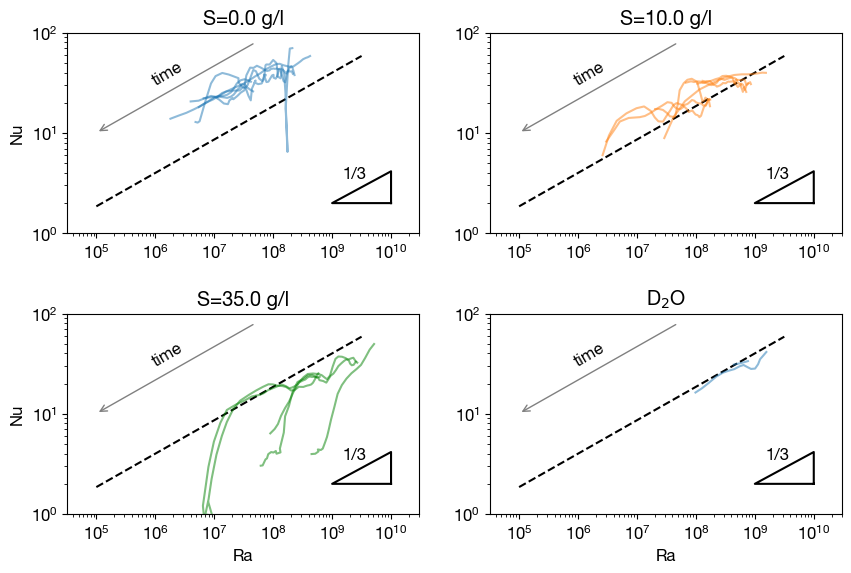

In [32]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/'
cylinders = ['2023-09-14/1st','2023-09-20/1st', '2023-09-12/1st','2023-09-12/2nd', '2023-10-17/2nd','2023-10-17/1st', # S=0, last is NR
             '2023-10-16/1st','2023-10-16/2nd', '2023-10-19/1st','2023-12-08/1st','2023-12-08/2nd','2023-12-15/1st','2023-12-19/1st',# S=10
             '2023-10-03/1st','2023-10-03/2nd','2023-10-04/3rd','2023-10-12/1st','2023-10-13/1st',# S=35
             '2023-12-01/2nd','2023-12-04/1st']# D2O

myColours = np.repeat(['tab:blue','tab:orange','green','purple','red','cyan','brown','pink','grey','olive',
                       'black','lime'],1)
myMarkers = ['s','^','o']

chosen_radii = [0.025,0.0405,0.06]
chosen_salts = [0.,10.,35.,]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(10,6.25),gridspec_kw={'wspace':0.2,'hspace':0.4})

for ic,cylinder in enumerate(cylinders):
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    contours_per_shot = int(contoursPATH[1][-5]) - 1 # fraction of contours over number of shots
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    if exp_radius == 0.06: 
        interval = 30
    else:
        interval = 10

    radii = []
    perimeters = []
    areas = []
    heights = []
    for it,contourPATH in enumerate(contoursPATH):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        polygon = Polygon(contour)
        radius = np.sqrt(polygon.area/np.pi)
        radii.append(radius)    
        perimeters.append(float(polygon.length))
        areas.append(polygon.area)
        heights.append(max(contour[:,1])-min(contour[:,1]))
    
    radii = remove_and_interpolate_outliers(radii)
    areas= remove_and_interpolate_outliers(areas)
    # perimeters = correct_outliers(perimeters)

    conversion = info[1,1]/radii[0] # m/px
    radii = np.array(radii)
    radii *= conversion
    perimeters = np.array(perimeters)
    perimeters *= conversion
    areas = np.array(areas)
    areas *= conversion**2
    heights = np.array(heights)
    heights *= conversion

    if exp_sal == 0.:
        axi = ax.flatten()[0]
    elif exp_sal == 10.:
        axi = ax.flatten()[1]
    elif exp_sal == 35.:
        axi = ax.flatten()[2]
    elif np.isnan(exp_sal):
        axi = ax.flatten()[3]

    Rayleigh_numbers = Ra_salinity(np.sqrt(areas),0,exp_wt,S=exp_sal)
    # Rayleigh_numbers = Ra_salinity(heights,0,exp_wt,S=exp_sal)
    if np.isnan(exp_sal): Rayleigh_numbers=Ra_heavyWater(np.sqrt(areas),exp_wt)
    if exp_sal==35.: Rayleigh_numbers = np.where(Rayleigh_numbers<1e6,np.nan,Rayleigh_numbers) # stupid line to remove a nasty outlier
    
    x = contours_per_shot*interval*np.arange(len(radii))
    # a_result, a_sigma = fit(func=f'np.polyval([a,b,c,{areas[0]}],x)',xdata=x,ydata=areas,draw=False,boolRetSigmas=True)
    # p_result, p_sigma = fit(func=f'np.polyval([a,b,c,{perimeters[0]}],x)',xdata=x,ydata=perimeters,draw=False,boolRetSigmas=True)
    # uNusselt_numbers = uNu_fit_per(a_params=a_result['params'],p_params=p_result['params'],t=x,a0=areas[0],p0=perimeters[0],T_water=exp_wt)
    # value = np.array([i.nominal_value for i in uNusselt_numbers])
    # std = np.array([i.std_dev for i in uNusselt_numbers])
    # markers, caps, bars = axi.errorbar(x=Rayleigh_numbers,y=value,yerr=[0+element*int(i%5/4) for i,element in enumerate(std)], # the error plots an error bar every 3 data points
    #              color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
    #              mfc='none',
    #              marker=myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
    #              alpha=0.5)
    
    a_result, a_sigma2, a_fitted = sliding_window_polyfit(x, areas, window_size=10)
    # p_result, p_sigma2, p_fitted = sliding_window_polyfit(x, perimeters, window_size=10)
    uNusselt_numbers = Nu_areas(a_fitted,exp_wt,x[1]-x[0])
    # value = np.array([i.nominal_value for i in uNusselt_numbers])
    # std = np.array([i.std_dev for i in uNusselt_numbers])
    markers, caps, bars = axi.errorbar(x=Rayleigh_numbers,y=uNusselt_numbers,yerr=0, 
                 color=myColours[np.where(chosen_salts==find_nearest(chosen_salts,exp_sal))[0][0]],
                 mfc='none',
                 marker='none',#myMarkers[np.where(chosen_radii==find_nearest(chosen_radii,exp_radius))[0][0]],
                 alpha=0.5)


    [bar.set_alpha(0.5) for bar in bars]
    if not np.isnan(exp_sal):
        axi.set_title(f'S={exp_sal} g/l')
    else:
        axi.set_title('D'+r'$_2$'+'O')
    
text_loc=[]
for ia,axi in enumerate(ax.flatten()):
    axi.plot(np.logspace(5,9.5,50),0.04*np.logspace(5,9.5,50)**(1/3),linestyle='--',c='k',label=r'$Nu=Ra^{1/3}$')
    axi.plot([1e10,1e10,1e9,1e10],[2,10**(1/3)+2,2,2],c='k')
    # axi.text(s=r'1/3',x=1.5e9,y=3.5)
    # axi.annotate(text='', xy=(5e7,8e1), xytext=(1e5,8e1), arrowprops=dict(arrowstyle='<-',color='Grey'))
    axi.text(s=r'1/3',x=1.5e9,y=3.5)
    axi.annotate(text='', xy=(5e7,8e1), xytext=(1e5,1.007e1), arrowprops=dict(arrowstyle='<-',color='Grey'))
    axi.text(s='time',x=8e5,y=3e1,rotation=30)
    axi.set(ylabel='Nu', xlabel='Ra',
            yscale='log',xscale='log',
            xlim=(10**4.5,3e10),ylim=(1e0,1e2))
    if axi == ax.flatten()[0] or axi == ax.flatten()[1]:
        axi.set_xlabel('')
    if axi == ax.flatten()[1] or axi == ax.flatten()[3]:
        axi.set_ylabel('')

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/NuRa.pdf',format='pdf',bbox_inches='tight')
plt.show()

# Plot all contours

### Freshwater

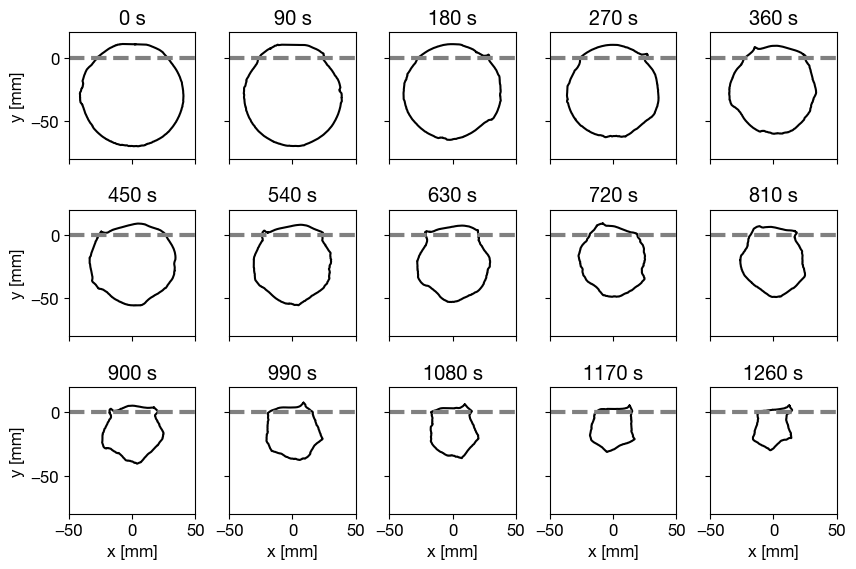

20.9 5.11e+07
24660.865375462174


In [7]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-09-20/'
cylinders = ['1st']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(10,6.25),gridspec_kw={'wspace':0.2,'hspace':0.4})

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))

    radii = []
    step = 3
    for it,contourPATH in enumerate(contoursPATH[:-7:step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]

        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k')
        ax.flatten()[it].hlines(0,-50,50,linestyles='--',linewidth=3,colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set(aspect='equal',
            xlabel='x [mm]',ylabel='y [mm]',
            title = f'{it*30*step} s',
            ylim=(-80,20),xlim=(-50,50),
            )
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    # axi.grid()

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/freshWater.pdf',format='pdf',bbox_inches='tight')
plt.show()
print(exp_wt,f'{Ra(exp_radius,0,exp_wt):.2e}')
print(conversion)

### Heavy water

18.700000000000003 4.87e+08


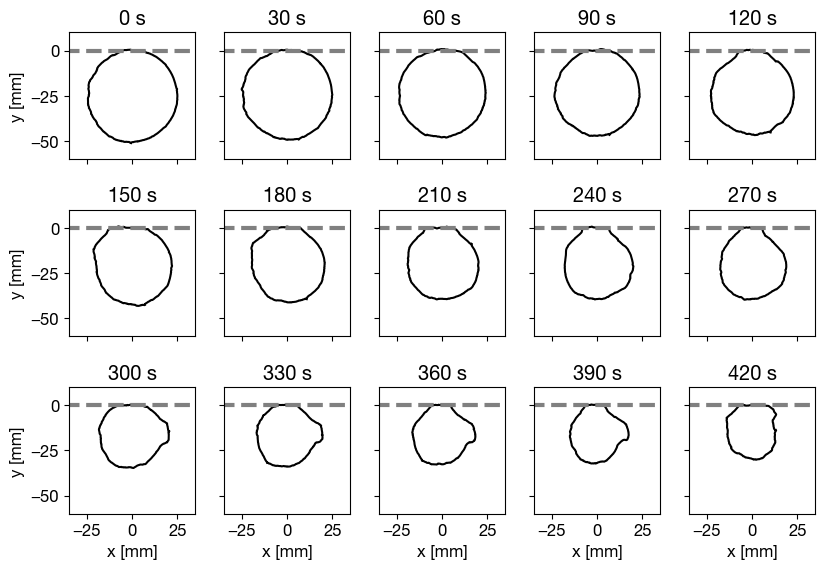

In [6]:
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-01/'
cylinders = ['2nd']

fig, ax = plt.subplots(nrows=3,ncols=5,figsize=(10,6.25),gridspec_kw={'wspace':0.0,'hspace':0.4})

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra_heavyWater(exp_radius,exp_wt):.2e}')

    radii = []
    step = 1
    for it,contourPATH in enumerate(contoursPATH[::step]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*8/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        xcenter = np.mean(contour,axis=0)[0]
        
        if it==len(ax.flatten()):break
        wl = findWL(contour,densityRatio=1003/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        ax.flatten()[it].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k')
        ax.flatten()[it].hlines(0,-50,50,linestyles='--',linewidth=3,colors='grey')

for it,axi in enumerate(ax.flatten()):
    axi.set(aspect='equal',
            xlabel='x [mm]',ylabel='y [mm]',
            title = f'{it*30*step} s',
            ylim=(-60,10),xlim=(-35,35),
            )
    if it%5!=0: 
        axi.set_ylabel('')
        axi.set_yticklabels('')
    if it<10:
        axi.set_xlabel('')
        axi.set_xticklabels('')
    # axi.grid()

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/heavyWater.pdf',format='pdf',bbox_inches='tight')
plt.show()

### Salty water and no rotation

18.45 1.75e+08
20.35 4.79e+07


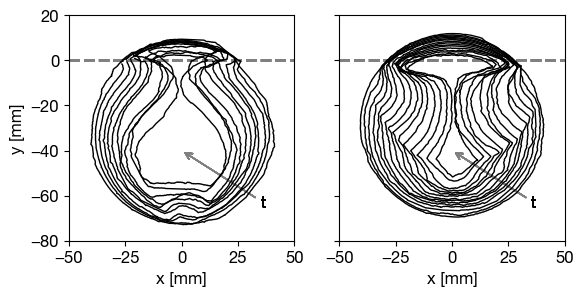

In [5]:
fig,axs = plt.subplots(ncols=2,nrows=1,figsize=(6.4,3.2))

# salty water
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-12-08/'
cylinders = ['1st']

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra_salinity(exp_radius,0,exp_wt,exp_sal):.2e}')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[::4]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*3.5/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        wl = findWL(contour,densityRatio=917/1005)  ### CHANGE FOR FRESH/SALTY WATER!!
        axs[1].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k',zorder=10,linewidth=1)
        axs[1].hlines(0,-50,50,linestyles='--',linewidth=2,colors='grey')
        axs[1].annotate(text='t', xy=(0,-40), xytext=(35,-65), arrowprops=dict(arrowstyle='->',color='Grey'))

# no rotation
directory = '/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/2023-10-17/'
cylinders = ['1st']

for cylinder in cylinders:
    dirContours = directory+cylinder+'/contours/'
    contoursPATH = []
    for contour in glob.glob(dirContours+'/*.csv'):
        contoursPATH.append(contour)
    contoursPATH = np.sort(contoursPATH)
    info = np.genfromtxt(dirContours+'info',delimiter=',')
    exp_radius,exp_sal,exp_wt = info[1,1],info[1,0],np.mean((info[1,2],info[1,4]))
    print(exp_wt,f'{Ra_salinity(exp_radius,0,exp_wt,exp_sal):.2e}')

    radii = []
    for it,contourPATH in enumerate(contoursPATH[:-15:3]):
        contour = np.genfromtxt(contourPATH,dtype='float',delimiter=',')
        if contour.shape[1]!=2: contour = contour.T
        if it==0: # straighten y direction
            shift = (max(contour[:,1])-min(contour[:,1]))*4/3
            radius = np.sqrt(PolyArea(contour[:,1],contour[:,0])/np.pi)
            conversion = radius/exp_radius # px/m
        contour[:,1 ] = -contour[:,1] + shift 
        contour = contour*1e3/conversion # in mm
        com,_ = hydrostasy(contour,densityRatio=917/1005)
        xcenter = com.x
        axs[0].plot(contour[:,0]-xcenter,contour[:,1]-wl,c='k',zorder=10,linewidth=1)
        axs[0].hlines(0,-50,50,linestyles='--',linewidth=2,colors='grey')
        axs[0].annotate(text='t', xy=(0,-40), xytext=(35,-65), arrowprops=dict(arrowstyle='->',color='Grey'))

# plot
for axi in axs:
    axi.set(aspect='equal',
            xlim=(-50,50),ylim=(-80,20),
            xlabel='x [mm]')
    # axi.grid()
axs[0].set_ylabel('y [mm]')
axs[1].set_yticklabels('')

# plt.savefig('/Users/edoardo/Library/CloudStorage/OneDrive-UniversityofTwente/floating/graphics/saltyWater_and_NR.pdf',format='pdf',bbox_inches='tight')
plt.show()